In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# load local version of gallifrey, before pip installed version, for debugging
import pathlib
import sys
import os

sys.path.append(str(pathlib.Path(os.getcwd()).parent.joinpath("src")))

In [47]:
import yt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gallifrey.setup import data_setup
from gallifrey.utilities.math import calculate_pca
from gallifrey.utilities.dataframe import (
    aggregated_dataframe,
    rename_labels,
    rename_galaxy_components,
)
from gallifrey.visualization.visualization_utils import (
    set_plot_defaults,
    get_palette,
    FigureProcessor,
    adjust_legend,
    ridgeplot,
)

## DATA SETUP

In [4]:
snapshot = 127
resolution = 8192
sim_id = "37_11"
num_embryos = 50
host_star_masses = 1
planet_categories = [
    "Earth",
    "Super-Earth",
    "Neptunian",
    "Sub-Giant",
    "Giant",
]

In [5]:
ds, mw, stellar_model, imf, planet_model, path = data_setup(
    snapshot=snapshot,
    resolution=resolution,
    sim_id=sim_id,
)


      DETECTED LOCAL MACHINE: Test snapshot loaded.

yt : [INFO     ] 2023-10-16 12:23:47,298 Calculating time from 1.000e+00 to be 4.318e+17 seconds
yt : [INFO     ] 2023-10-16 12:23:47,358 Parameters: current_time              = 4.318436660023809e+17 s
yt : [INFO     ] 2023-10-16 12:23:47,359 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-10-16 12:23:47,359 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-10-16 12:23:47,360 Parameters: domain_right_edge         = [100. 100. 100.]
yt : [INFO     ] 2023-10-16 12:23:47,360 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-10-16 12:23:47,360 Parameters: current_redshift          = 4.440892098500626e-16
yt : [INFO     ] 2023-10-16 12:23:47,361 Parameters: omega_lambda              = 0.682
yt : [INFO     ] 2023-10-16 12:23:47,361 Parameters: omega_matter              = 0.318
yt : [INFO     ] 2023-10-16 12:23:47,361 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 202

In [39]:
set_plot_defaults()

figure_subdirectory = f"MilkyWayAnalogue/{mw.resolution}/{mw.sim_id}/{mw.snapshot}/Component_populations/host_star_mass_={host_star_masses}"
save = True

## CREATE DATA SOURCE

In [7]:
radius = 0.2 * mw.virial_radius()
sphere_data = mw.sphere(radius=radius)

In [8]:
components = ["bulge_stars", "thin_disk_stars", "thick_disk_stars", "halo_stars"]
data = aggregated_dataframe(
    components,
    ["planet_hosting_number", *planet_categories],
    data_source=sphere_data,
    type_name="Component",
)

# rename components
data = rename_galaxy_components(data)

## Planet Populations Per Component

In [9]:
number_of_planets = data.groupby("Component")[planet_categories].sum()
number_of_host_stars = data.groupby("Component")["planet_hosting_number"].sum()
occurence_rate = number_of_planets.div(number_of_host_stars, axis=0).reset_index()

occurence_rate_long_format = occurence_rate.melt(
    id_vars="Component",
    var_name="Planet Type",
    value_name="Occurence Rate",
)

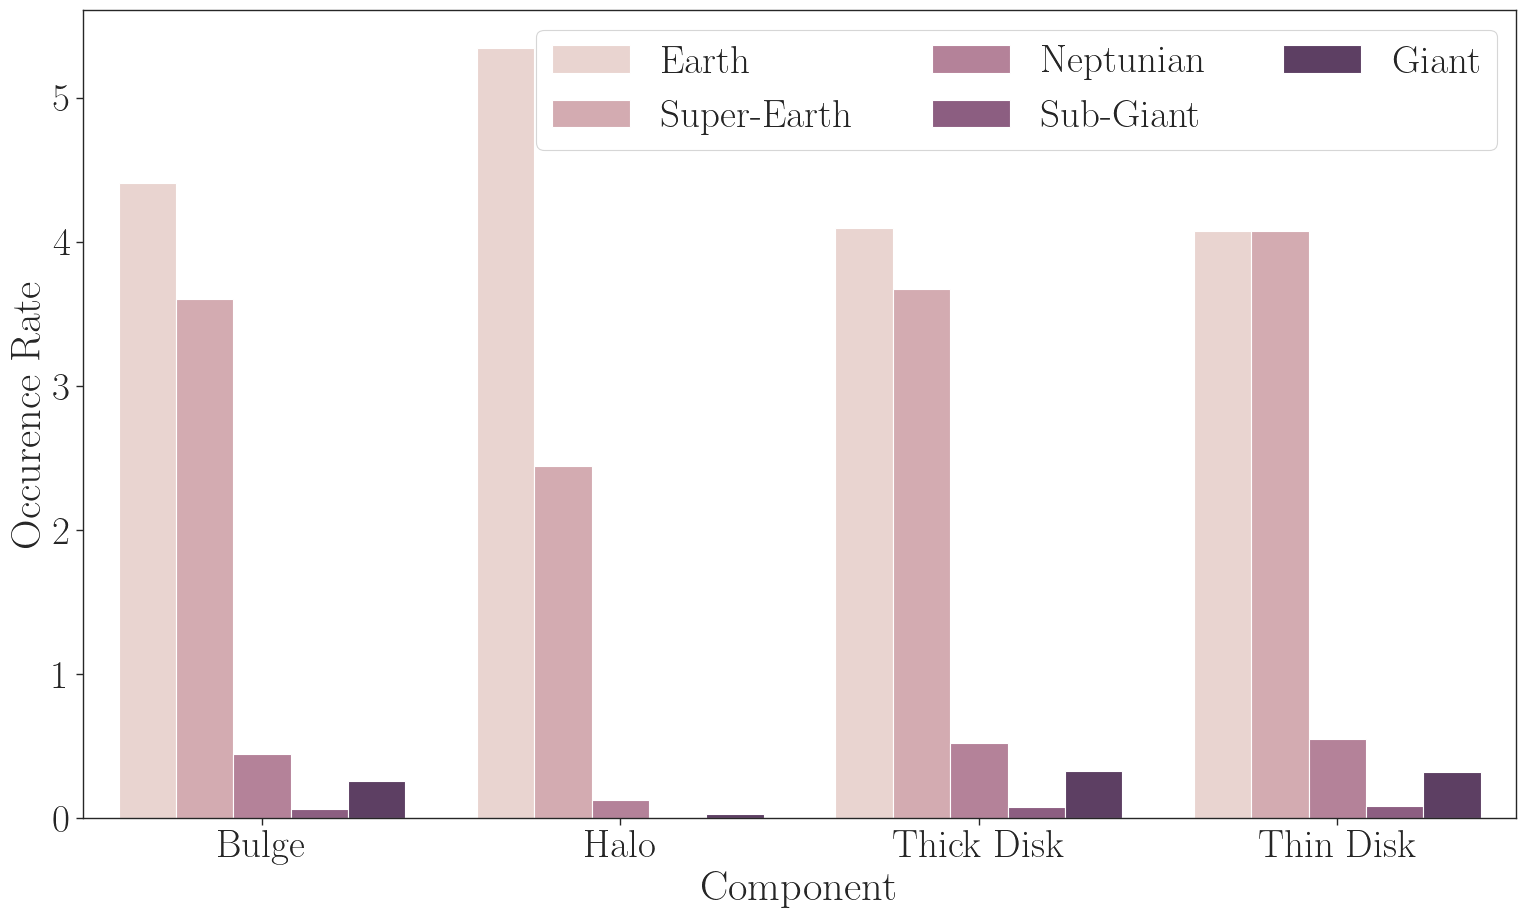

In [57]:
with sns.axes_style("ticks"):
    occurence_rate_barplot = sns.barplot(
        data=occurence_rate_long_format,
        x="Component",
        y="Occurence Rate",
        hue="Planet Type",
        log=False,
        palette=get_palette(),
    )
# adjust legend
occurence_rate_barplot = adjust_legend(occurence_rate_barplot, pad=1)

FigureProcessor(occurence_rate_barplot.figure).save(
    "occurence_rates.pdf",
    sub_directory=figure_subdirectory,
    save=save,
)